In [ ]:
import jax
import jax.numpy as jnp
import itertools
import pennylane as qml
import numpy as np
from jax.experimental.sparse import BCOO
from scipy.linalg import expm
import tensorcircuit as tc
import pandas as pd
import os
from tqdm import tqdm
import basefunction

def large_scale_circuit(params, num_qubits, initial_state):
    tc.set_backend("jax")
    c = tc.Circuit(num_qubits, inputs=initial_state)
    for qubit in range(num_qubits):
        c.rx(qubit, theta=params[qubit, 0])
        c.ry(qubit, theta=params[qubit, 1])
        c.rz(qubit, theta=params[qubit, 2])
    return c.state()

def test_circuit(inistr, params):
    num_qubits = len(inistr)
    initial_state = basefunction.str2rhoinistr(inistr)
    state_ode = large_scale_circuit(params, num_qubits, initial_state)
    return state_ode


def errormitigation_process(resultin, resultout):
    transition_matrix = basefunction.build_coo_matrix(np.array(resultin), np.array(resultout)).transpose()
    daggertransition_matrix = basefunction.normalize_coo_matrix(transition_matrix)
    rhoin_d = jnp.array(sorted({tuple(s) for s in np.array(resultin)}))
    expvals_d0 = jax.vmap(basefunction.optimized_compute_multi_trace_stab2, in_axes=(0, None))(O_terms, rhoin_d)
    expvals_d1 = jax.vmap(lambda x, c: x * c)(expvals_d0, jnp.array(coeffs))
    expvals_d = jnp.sum(expvals_d1, axis=0)
    rhoout_d = daggertransition_matrix @ expvals_d
    rhoin_d = jnp.array(sorted({tuple(s) for s in np.array(resultout)}))
    
    @jax.jit
    def compute_xp_betap_alphap(P):
        prhoin_d = basefunction.optimized_compute_multi_trace(P, rhoin_d)
        results = prhoin_d * rhoout_d
        xp = jnp.mean(results)
        betap = (1/3) ** basefunction.count_non_I(P)
        alphap = basefunction.calculate_alpha_p(xp, betap, tilde_epsilon, eta)
        return alphap
    
    alphap_list = jax.vmap(compute_xp_betap_alphap)(all_pauli).astype(jnp.float32)
    noise_rho = Umatrix @ basefunction.str2rho(rhoinput) @ Umatrix.conj().T
    
    @jax.jit
    def compute_trace_term(alphap, pauli):
        return alphap * jnp.trace(basefunction.str2rho(pauli) @ noise_rho)
    
    alphap_arr = jnp.array(alphap_list)
    all_pauli_arr = jnp.array(all_pauli)
    results = jax.vmap(compute_trace_term)(alphap_arr, all_pauli_arr)
    dagger_result = jnp.sum(results)
    ideal_tr = jnp.trace(observation @ basefunction.str2rho(rhoinput))
    noise_tr = jnp.trace(observation @ noise_rho)
    return noise_tr, ideal_tr, dagger_result

def matrix_representation(params, num_qubits):
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    
    def rx(theta):
        return expm(-0.5j * theta * sigma_x)
    def ry(theta):
        return expm(-0.5j * theta * sigma_y)
    def rz(theta):
        return expm(-0.5j * theta * sigma_z)
    
    U_total = np.eye(1, dtype=complex)
    for qubit in range(num_qubits):
        theta_x, theta_y, theta_z = params[qubit, 0], params[qubit, 1], params[qubit, 2]
        U_qubit = rz(theta_z) @ ry(theta_y) @ rx(theta_x)
        U_total = np.kron(U_total, U_qubit)
    return U_total
if __name__ == "__main__":
    num_qubits = 4
    params = jnp.array([[0.82, 0.75, 0.46], [0.24, 0.43, 0.55], [0.82, 0.75, 0.46], [0.24, 0.43, 0.55]])
    # coeffs, terms = basefunction.calculate_observable(num_qubits, 0.27, 0.42, 0.76, 0.6, 0.4)
    coeffs, terms = basefunction.calculate_observable_zglobal(num_qubits)
    O_terms = jnp.array(basefunction.convert_terms(terms, num_qubits))
    observation = qml.matrix(qml.Hamiltonian(coeffs, terms))
    Umatrix = matrix_representation(params, num_qubits)
    keys_list = basefunction.vakey(num_qubits)
    kappa = 2
    d = 7
    epsilon = 0.4
    delta = 0.01
    eta = sum(map(abs, coeffs))
    k = 4
    tilde_epsilon = epsilon / (9 * 2 **(k + 1) * num_qubits** k) * ((basefunction.cal_C_k_d(kappa, d) / 3) **2)
    all_pauli = jnp.array([list(item) for item in itertools.product([6, 7, 8, 9], repeat=num_qubits) if item.count(7) + item.count(8) + item.count(9) <= k])

    Norigin = [3,3.5,4,4.5,5,5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10.0, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15.0, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20.0]
    sample_sizes = [int(Norigin[i] * 10000) for i in range(len(Norigin))]

    resultin_list, resultout_list = basefunction.load_results(num_qubits, f'./shadows/{num_qubits}qubits_error_mitigation_shadows.csv')
    jax.config.update("jax_enable_x64", True)

    num_runs = 500
    results = []
    qubits = [i for i in range(num_qubits)]

    filename = "./data/4_qubits_error_mitigation_ratio.csv"

    if not os.path.exists(filename):
        pd.DataFrame(columns=['N', 'ratio']).to_csv(filename, index=False)

    ratio_data = []

    for i, N in tqdm(enumerate(sample_sizes), total=len(sample_sizes), desc="Processing sample sizes"):
        run_ratios = []
        for times in range(num_runs):
            resultin = resultin_list[times][:N]
            resultout = resultout_list[times][:N]
            
            noise_tr, ideal_tr, dagger_result = errormitigation_process(resultin, resultout)
            
            numerator = np.abs(ideal_tr - dagger_result)
            denominator = np.abs(ideal_tr - noise_tr)
            
            if denominator == 0:
                ratio = 0.0
            else:
                ratio = numerator / denominator
            
            run_ratios.append(ratio)
        
        avg_ratio = np.mean(run_ratios)
        ratio_data.append({'N': N, 'ratio': avg_ratio})

    pd.DataFrame(ratio_data).to_csv(filename, mode='a', header=False, index=False, float_format='%.6f')





    

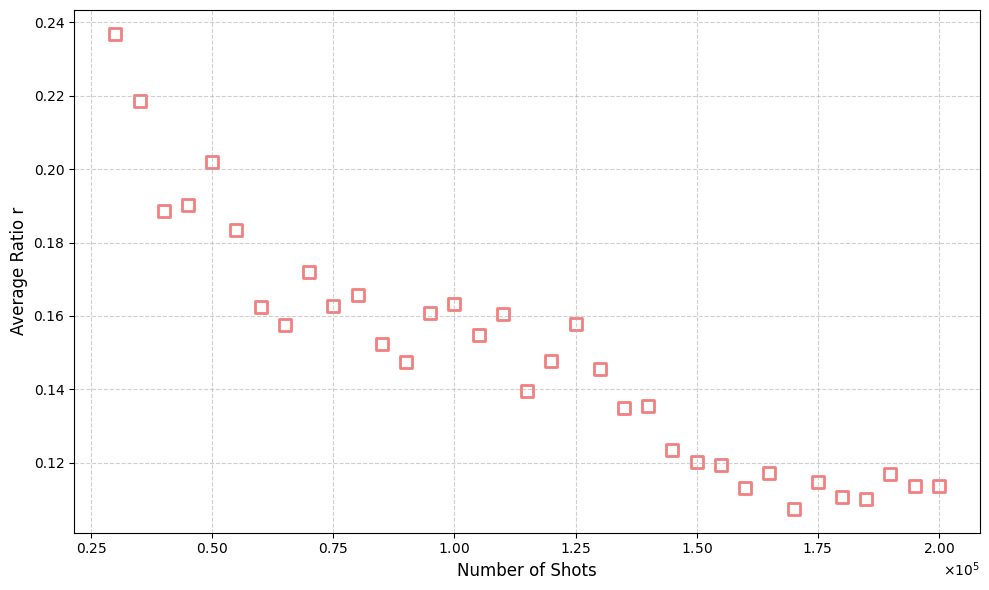

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter

# Load ratio result file
df = pd.read_csv("./data/4_qubits_error_mitigation_ratio.csv")

# Set figure size
plt.figure(figsize=(10, 6))

# Plot scatter chart
plt.scatter(
    df['N'],
    df['ratio'],
    color='white',
    marker='s',
    s=65,
    edgecolor='#F28080',
    linewidths=2
)

# Set axis format (scientific notation)
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 4))

# Add axis labels
plt.xlabel('Number of Shots', fontsize=12)
plt.ylabel('Average Ratio r', fontsize=12)

# Set grid
plt.grid(True, linestyle='--', alpha=0.6)

# Optimize layout and save
plt.tight_layout()
plt.savefig('fig3.svg', format='svg', bbox_inches='tight')
plt.show()